### Esercitazione 11 - RSI (Relative Strength Index)
#### Argomenti

* indicatori Momentum
* indicatore RSI
* ricerca dei picchi massimi e minimi di prezzo
* identificazione dei trend di prezzo
* analisi delle divergenze tra i trend di prezzo e RSI
* implementazione di due strategie basate sull'utilizzo dell'RSI e di grafici custom per l'analisi dei risultati

Gli indicatori Momentum sono degli strumenti di analisi tecnica usati per determinare
la forza o la debolezza di uno strumento finanziario, misurando il tasso di crescita
(o decrescita) dei relativi prezzi.

L'indice di forza relativa (RSI) è un indicatore di momentum utilizzato comunemente
nell'analisi tecnica. L'RSI misura la velocità e l'entità delle recenti variazioni
di prezzo di uno strumento finanziario per valutare condizioni sopravvalutate o
sottovalutate nel prezzo.

L'RSI viene visualizzato come un oscillatore (un grafico a linee) su una scala da
0 a 100. Può fare di più che indicare titoli ipercomprati e ipervenduti: può anche
indicare titoli che potrebbero essere pronti per un'inversione di tendenza
o un ritiro correttivo del prezzo. Può segnalare così quando acquistare e vendere.
Tradizionalmente, una valore RSI di 70 o superiore indica una situazione di ipercomprato.
Un valore di 30 o inferiore indica una condizione d'ipervenduto.

Si può utilizzare l'RSI per prevedere il comportamento del prezzo di un titolo; può aiutare
a convalidare le tendenze e le inversioni di tendenza, può indicare gli strumenti finanziari
ipercomprati e ipervenduti.
Su trading veloci (intraday) può fornire segnali di acquisto e vendita.
È normalmente utilizzato con altri indicatori / oscillatori per supportare le strategie
di trading.

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import argrelextrema
from collections import deque
import numpy as np

In [2]:
connected = mt5.initialize(login=5776609, server="ActivTrades-Server", password='YDSNcmto')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_D1, 0, 500))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

La seguente formula illustra il modo in cui l'RSI è calcolato:

RSI = 100 - (100 / (1 + (guadagno_medio / perdita_media)))

Il guadagno e perdita medi sono calcolati in percentuale durante il periodo (n candele) di riferimento e la perdita
media utilizza un valore positivo e non negativo.
I periodi con perdite vengono conteggiati come zero nei calcoli del guadagno medio e quelli con
guadagni vengono conteggiati come zero nei calcoli delle perdite.

Se, ad esempio, consideriamo n = 14 periodi (valore standard); in questi su 9 periodi si è avuta una perdita
media dell'1.1% e nei restanti 5 periodi un guadagno medio dello 0.9%, otterremo:

RSI = 100 - (100 / (1 + (0.9 / 1.1))) = 100 - (100 / (1 + 0.82) = 100 - (100 / 1.82) = 45.5

Diminuendo il valore n degli intervalli selezionati per il calcolo dell'RSI (14 nel nostro esempio), si hanno
due effetti:
* migliora la reattività dell’oscillatore rispetto all’andamento dei prezzi (subisce meno ritardo rispetto all'andamento
reale dei prezzi)
* diminuisce l’importanza dei movimenti e dei segnali dell’RSI, risultando meno attendibili

Aumentando il numero di periodi / candele selezionati, si hanno gli effetti opposti.

In [3]:
# utilizziamo Ta-Lib per il calcolo dell'RSI
candles['rsi'] = talib.RSI(candles['close'], timeperiod=14)

candles.tail()

,open,high,low,close,tick_volume,spread,real_volume,rsi
time,,,,,,,,
2022-10-28,0.99635,0.99979,0.99254,0.99638,153333,5,0,56.972443
2022-10-30,0.99458,0.99600,0.99432,0.99571,4703,5,0,56.440171
2022-10-31,0.99570,0.99654,0.98711,0.98842,97752,5,0,50.871161
2022-11-01,0.98841,0.99536,0.98522,0.98740,126971,5,0,50.125899
2022-11-02,0.98735,0.99114,0.98706,0.98959,51340,5,0,51.759980


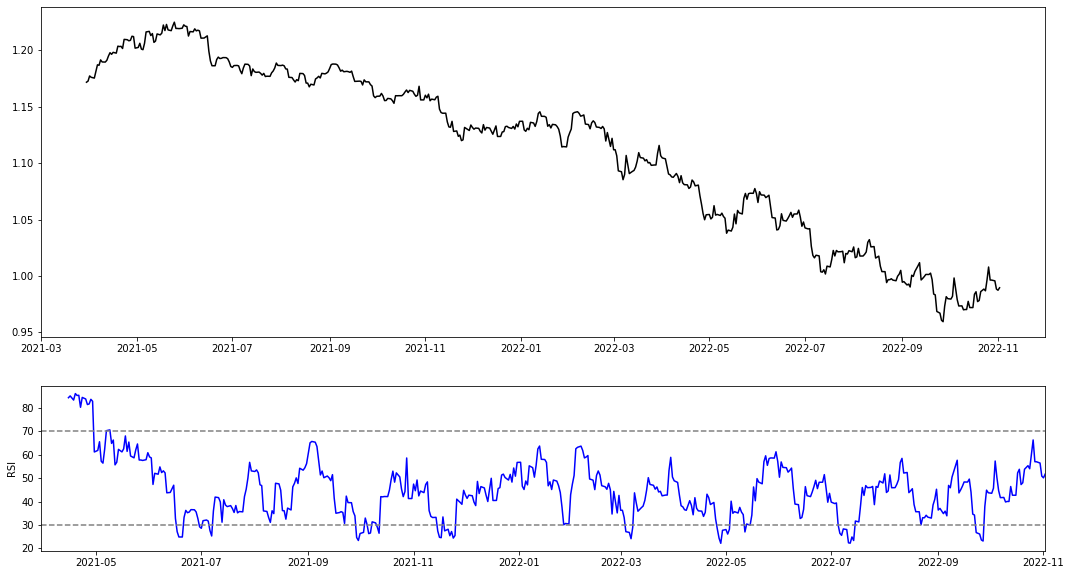

In [4]:
# visualizzazione dell'RSI su un grafico

fig, (ax_price, ax_rsi) = plt.subplots(2, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})

ax_price.plot(candles.index, candles['close'], color='black')
plt.autoscale(True, axis='x', tight=True)

ax_rsi.plot(candles.index, candles['rsi'], color='blue')
ax_rsi.hlines(30, xmin=candles.index[0], xmax=candles.index[-1], color='gray', linestyle='--')
ax_rsi.hlines(70, xmin=candles.index[0], xmax=candles.index[-1], color='gray', linestyle='--')
ax_rsi.set_ylabel('RSI')

plt.show()

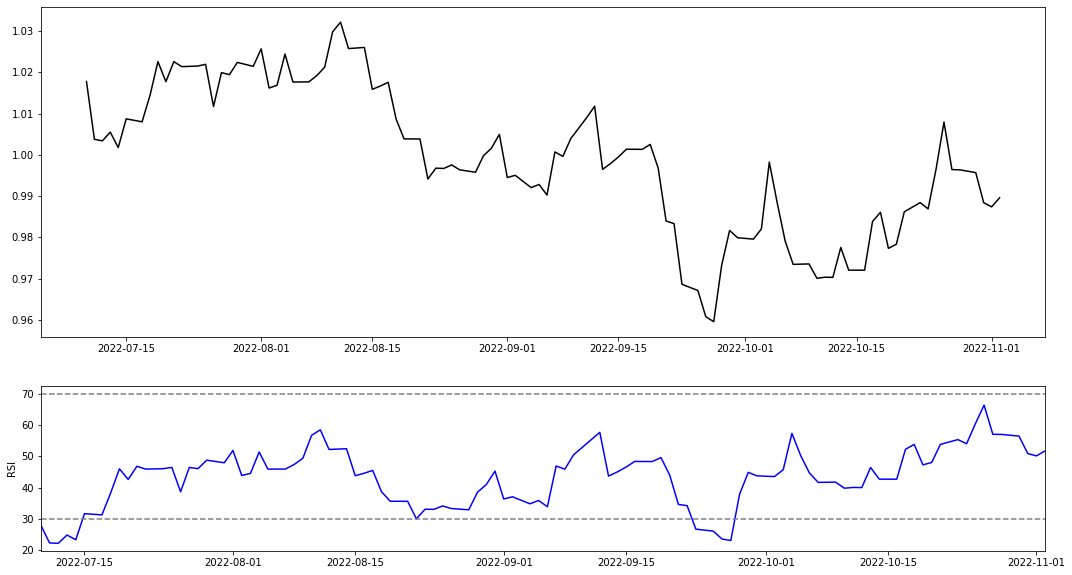

In [5]:
fig, (ax_price, ax_rsi) = plt.subplots(2, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})

ax_price.plot(candles.index[-100:], candles['close'][-100:], color='black')
plt.autoscale(True, axis='x', tight=True)

ax_rsi.plot(candles.index[-100:], candles['rsi'][-100:], color='blue')
ax_rsi.hlines(30, xmin=candles.index[-100], xmax=candles.index[-1], color='gray', linestyle='--')
ax_rsi.hlines(70, xmin=candles.index[-100], xmax=candles.index[-1], color='gray', linestyle='--')
ax_rsi.set_ylabel('RSI')

plt.show()

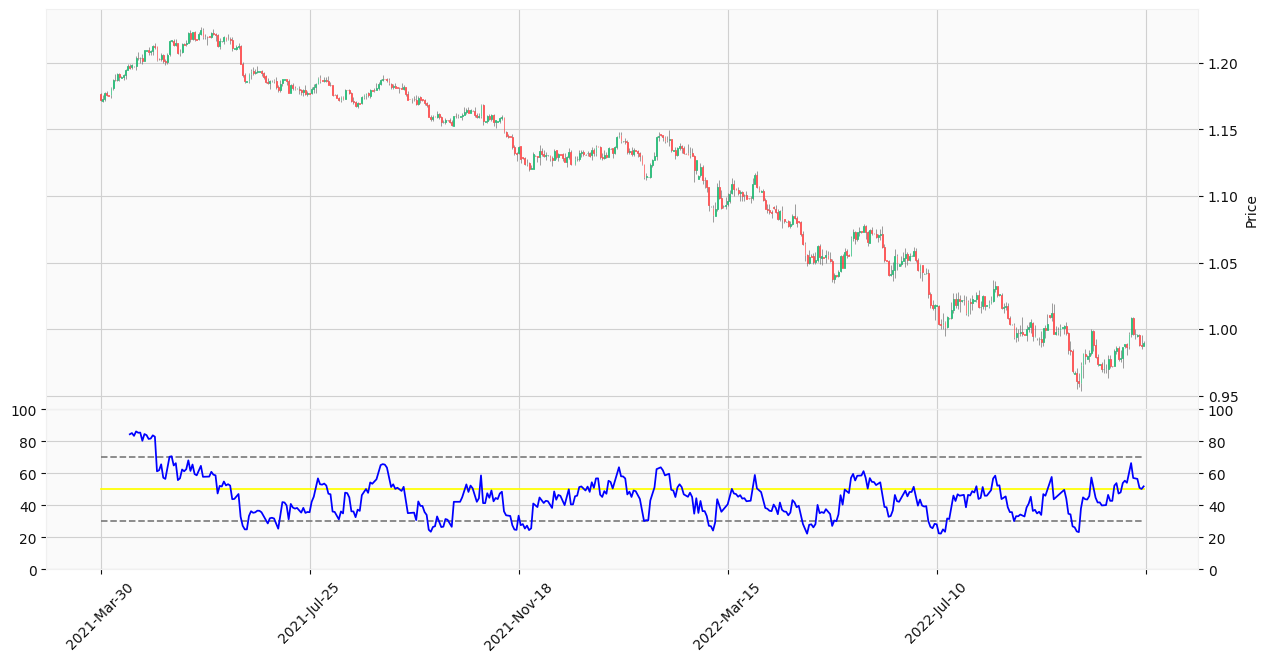

In [6]:
n_candele = len(candles)

rsi_plot = mpf.make_addplot(candles['rsi'], color='blue', panel=1, ylim=(0, 100))
rsi_upper_plot = mpf.make_addplot([70] * n_candele, color='gray', linestyle='--', panel=1, ylim=(0, 100))
rsi_middle_plot = mpf.make_addplot([50] * n_candele, color='yellow', panel=1, ylim=(0, 100))
rsi_lower_plot = mpf.make_addplot([30] * n_candele, color='gray', linestyle='--', panel=1, ylim=(0, 100))
mpf.plot(candles, addplot=[rsi_upper_plot, rsi_middle_plot, rsi_lower_plot, rsi_plot], type='candle', style='yahoo', figsize=(16, 8))

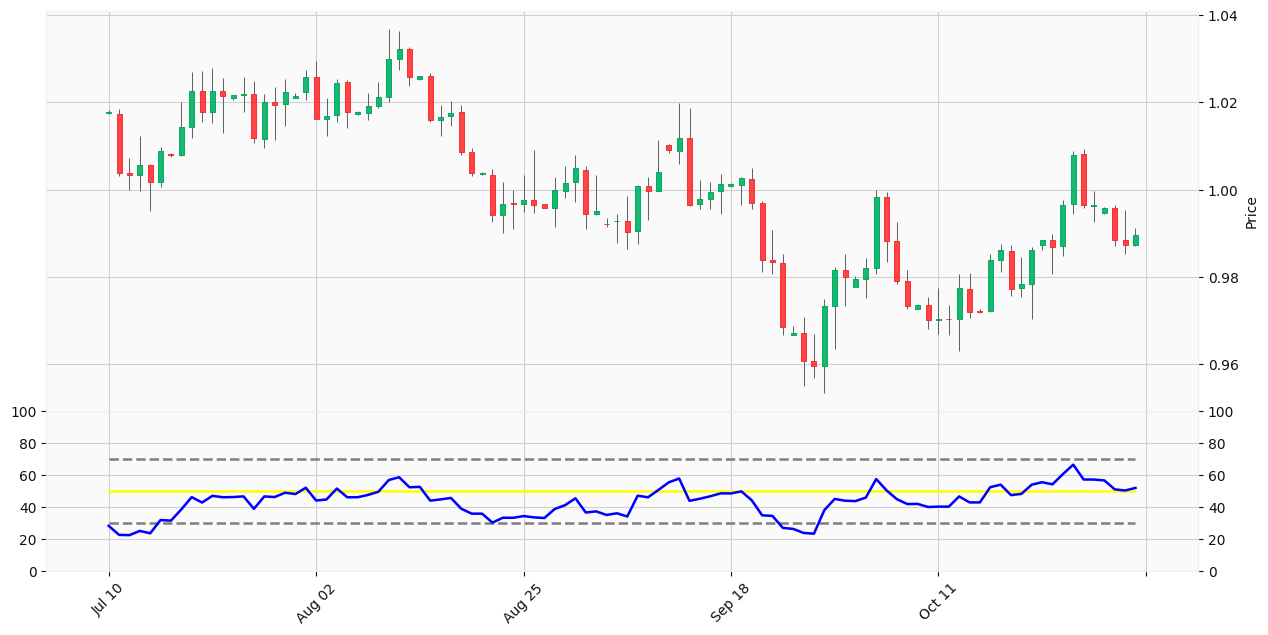

In [7]:
n_candele = 100

rsi_plot = mpf.make_addplot(candles['rsi'][-100:], color='blue', panel=1, ylim=(0, 100))
rsi_upper_plot = mpf.make_addplot([70] * n_candele, color='gray', linestyle='--', panel=1, ylim=(0, 100))
rsi_middle_plot = mpf.make_addplot([50] * n_candele, color='yellow', panel=1, ylim=(0, 100))
rsi_lower_plot = mpf.make_addplot([30] * n_candele, color='gray', linestyle='--', panel=1, ylim=(0, 100))
mpf.plot(candles[-100:], addplot=[rsi_upper_plot, rsi_middle_plot, rsi_lower_plot, rsi_plot], type='candle', style='yahoo', figsize=(16, 8))

### Divergenze

Una divergenza nell'RSI si verifica quando il prezzo si muove nella direzione opposta a quella dell'RSI.

Una divergenza rialzista è caratterizzata da un aumento dei valori minimi di RSI, mentre questo si mantiene in
zona d'ipervenduto (ad es. <30) e i prezzi scendono. Ciò potrebbe indicare un aumento dello slancio rialzista e una
rottura al di sopra del territorio d'ipervenduto potrebbe essere utilizzata per innescare una nuova posizione lunga.

Una divergenza ribassista si verifica quando l'RSI presenta valori di ipercomprato mentre i suoi valori massimi
diminuiscono e i prezzi salgono.

### implementazione di una procedura per l'identificazione delle divergenze rialziste e ribassiste tra RSI e prezzo

In [8]:
# metodi per il rilevamento dei picchi (minimi / massimi) consecutivi nei livelli di prezzo
# in modo da evidenziarne il trend, per poterlo poi confrontare con quello generato dall'RSI
# alla ricerca di convergenze e divergenze per generare segnali

def picchi_crescenti_consecutivi(data, order=5, K=2):
    '''
    Trova massimi crescenti consecutivi in [data]
    order: indica quanti dati consecutivi considerare in ogni finestra
    K: indica quanti picchi consecutivi si devono avere per confermare la condizione di massimi crescenti consecutivi
    '''
    high_idx = argrelextrema(data, np.greater, order=order)[0]
    highs = data[high_idx]
    # check per verificare che i livelli selezionati siano consecutivi
    picchi = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
        elif highs[i] < highs[i - 1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            picchi.append(ex_deque.copy())
    return picchi


# similmente possiamo implementare:

def picchi_decrescenti_consecutivi(data: np.array, order=5, K=2):
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    picchi = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
        elif lows[i] > lows[i - 1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            picchi.append(ex_deque.copy())
    return picchi

In [9]:
prices = candles['close'].values
highs = candles['high'].values
lows = candles['low'].values
dates = candles.index

order = 5
# XY -> X = crescente/decrescente, Y = massimi/minimi
hh = picchi_crescenti_consecutivi(highs, order)
lh = picchi_decrescenti_consecutivi(highs, order)
hl = picchi_crescenti_consecutivi(lows, order)
ll = picchi_decrescenti_consecutivi(lows, order)

# recupero l'id finale di ogni intervallo (id_inizio_intervallo, id_fine_intervallo)
hh_idx = np.array([i[1] for i in hh])
lh_idx = np.array([i[1] for i in lh])
ll_idx = np.array([i[1] for i in ll])
hl_idx = np.array([i[1] for i in hl])

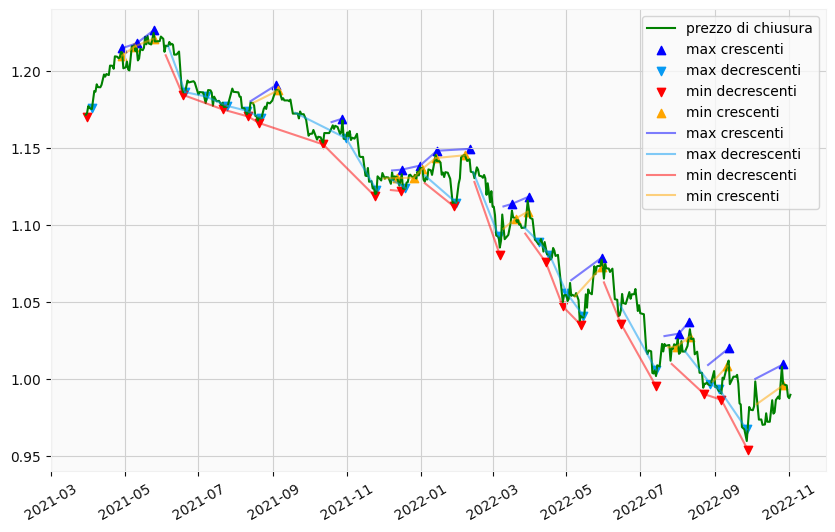

In [10]:
# visualizzazione dei picchi e dei relativi trend

plt.figure(figsize=(10, 6))
plt.xticks(rotation=30)

plt.plot(candles['close'], color='green', label='prezzo di chiusura')

plt.scatter(dates[hh_idx], highs[hh_idx], marker='^', c='blue', label='max crescenti')
plt.scatter(dates[lh_idx], highs[lh_idx], marker='v', c='#069AF3', label='max decrescenti')
plt.scatter(dates[ll_idx], lows[ll_idx], marker='v', c='red', label='min decrescenti')
plt.scatter(dates[hl_idx], lows[hl_idx], marker='^', c='orange', label='min crescenti')

for i in hh:
    if i == hh[0]:
        plt.plot(dates[i], highs[i], c='blue', alpha=0.5, label='max crescenti')
    else:
        plt.plot(dates[i], highs[i], c='blue', alpha=0.5)
for i in lh:
    if i == lh[0]:
        plt.plot(dates[i], highs[i], c='#069AF3', alpha=0.5, label='max decrescenti')
    else:
        plt.plot(dates[i], highs[i], c='#069AF3', alpha=0.5)
for i in ll:
    if i == ll[0]:
        plt.plot(dates[i], lows[i], c='red', alpha=0.5, label='min decrescenti')
    else:
        plt.plot(dates[i], lows[i], c='red', alpha=0.5)
for i in hl:
    if i == hl[0]:
        plt.plot(dates[i], lows[i], c='orange', alpha=0.5, label='min crescenti')
    else:
        plt.plot(dates[i], lows[i], c='orange', alpha=0.5)

plt.legend()
plt.show()

In [11]:
# metodi per il recupero degli indici dei picchi HH, LH, HL, LL

def get_indici_picchi_crescenti_consecutivi(data: np.array, order=5, K=2):
    picchi = picchi_crescenti_consecutivi(data, order, K)
    idx = np.array([i[-1] for i in picchi])
    return idx


def get_indici_picchi_decrescenti_consecutivi(data: np.array, order=5, K=2):
    picchi = picchi_decrescenti_consecutivi(data, order, K)
    idx = np.array([i[-1] for i in picchi])
    return idx

# metodo per rilevare i picchi (HH, HL, LH, LL) in una distribuzione di dati
def get_picchi(data, key, order=5, K=2):
    data = data.copy()
    vals = data[key].values
    hh_idx = get_indici_picchi_crescenti_consecutivi(vals, order, K)
    lh_idx = get_indici_picchi_decrescenti_consecutivi(vals, order, K)
    ll_idx = get_indici_picchi_decrescenti_consecutivi(vals, order, K)
    hl_idx = get_indici_picchi_crescenti_consecutivi(vals, order, K)
    data[f'{key}_highs'] = np.nan
    data.loc[data.iloc[hh_idx].index, f'{key}_highs'] = 1
    data.loc[data.iloc[lh_idx].index, f'{key}_highs'] = -1
    data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
    data[f'{key}_lows'] = np.nan
    data.loc[data.iloc[ll_idx].index, f'{key}_lows'] = -1
    data.loc[data.iloc[hl_idx].index, f'{key}_lows'] = 1
    data[f'{key}_lows'] = data[f'{key}_lows'].ffill().fillna(0)
    return data


def strategia_divergenze_rsi(data, interval=14, order=5, K=2):
    '''
    Si entra in buy/sell sulle divergenze tra prezzo e RSI:
    - Buy se il prezzo ha minimi decrescenti, RSI ha minimi crescenti e l'RSI è < 50
    - Sell se il prezzo ha massimi crescenti, RSI ha massimi decrescenti e l'RSI è > 50

    Si esce da una posizione quando l'RSI fa un ritracciamento sul suo valore al momento
    dell'apertura
    '''
    data = get_picchi(data, key='close', order=order, K=K)
    data['rsi'] = talib.RSI(data.close, timeperiod=interval)
    data = get_picchi(data, key='rsi', order=order, K=K)

    position = np.zeros(data.shape[0])
    for i, (t, row) in enumerate(data.iterrows()):
        if position[i - 1] == 0:
            # divergenza tra trend RSI e Prezzo + RSI nella fascia bassa-> buy
            if row['close_lows'] == -1 and row['rsi_lows'] == 1:
                if row['rsi'] < 50:
                    position[i] = 1
                    entry_rsi = row['rsi'].copy()

            # divergenza tra trend RSI e Prezzo + RSI nella fascia alta-> sell
            elif row['close_highs'] == 1 and row['rsi_highs'] == -1:
                if row['rsi'] > 50:
                    position[i] = -1
                    entry_rsi = row['rsi'].copy()

        # verifica se restare in buy
        elif position[i - 1] == 1:
            if row['rsi'] < entry_rsi:
                position[i] = 1

        # verifica se restare in sell
        elif position[i - 1] == -1:
            if row['rsi'] > entry_rsi:
                position[i] = -1

    data['position'] = position

    return data, get_returns(data)


def get_returns(df):
    '''
    metodo per la verifica dei guadagni / perdite
    riutilizzata anche nella strategia illustrata successivamente

    da notare che il calcolo del ritorno dell'investimento è ottenuto simulando di giocare su ogni candela in cui è
    generato un segnale +1 o -1, non considerando eventuali candele consecutive in un'unica giocata

    adoperando questa tecnica su un dataframe possiamo parallelizzare i calcoli velocizzandone l'esecuzione
    '''

    df['returns'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)

    df['strat_returns'] = df['position'] * df['returns']

    df['cum_returns'] = df['returns'].cumsum()
    df['strat_cum_returns'] = df['strat_returns'].cumsum()
    return df

In [12]:
# recupero dati storici e calcolo dei risultati della strategia basata sulle divergenze tra trend di prezzi e RSI

connected = mt5.initialize(login=5776609, server="ActivTrades-Server", password='YDSNcmto')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_D1, 0, 365))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

data, res = strategia_divergenze_rsi(candles, interval=14)

In [13]:
res.tail()

,open,high,low,close,tick_volume,spread,real_volume,close_highs,close_lows,rsi,rsi_highs,rsi_lows,position,returns,strat_returns,cum_returns,strat_cum_returns
time,,,,,,,,,,,,,,,,,
2022-10-28,0.99635,0.99979,0.99254,0.99638,153333,5,0,1.0,1.0,56.972443,1.0,1.0,0.0,-0.000060,-0.0,-0.171102,-0.085573
2022-10-30,0.99458,0.99600,0.99432,0.99571,4703,5,0,1.0,1.0,56.440171,1.0,1.0,0.0,-0.000672,-0.0,-0.171775,-0.085573
2022-10-31,0.99570,0.99654,0.98711,0.98842,97752,5,0,1.0,1.0,50.871161,1.0,1.0,0.0,-0.007321,-0.0,-0.179096,-0.085573
2022-11-01,0.98841,0.99536,0.98522,0.98740,126971,5,0,1.0,1.0,50.125899,1.0,1.0,0.0,-0.001032,-0.0,-0.180128,-0.085573
2022-11-02,0.98735,0.99114,0.98706,0.99038,56504,5,0,1.0,1.0,52.323470,1.0,1.0,0.0,0.003018,0.0,-0.177110,-0.085573


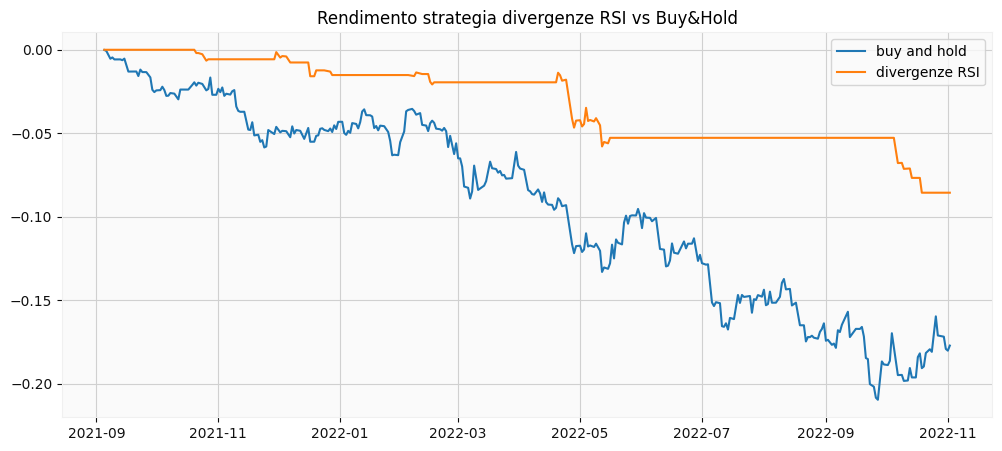

In [14]:
# visualizzazione del rendimento della strategia rispetto
# alla strategia "buy & hold"

plt.figure(figsize=(12, 5))
plt.plot(res['cum_returns'], label='buy and hold')
plt.plot(res['strat_cum_returns'], label='divergenze RSI')
plt.title('Rendimento strategia divergenze RSI vs Buy&Hold')
plt.legend()
plt.show()

In [15]:
# ulteriore strategia con sfruttamento medie mobili esponenziali
# come ulteriore segnale per chiudere una posizione

def _exp_moving_average(price, last_ema, n):
    return (price - last_ema) * (2 / (n + 1)) + last_ema


def exp_moving_average(data, key, n):
    # inizializzazione colonna media mobile semplice [sma_n]
    data['sma_' + str(n)] = data[key].rolling(n).mean()

    # inizializzazione valori media mobile esponenziale
    ema = np.zeros(len(data))

    for i, _row in enumerate(data.iterrows()):
        row = _row[1]
        if i < n:
            ema[i] += row['sma_' + str(n)]
        else:
            ema[i] += _exp_moving_average(row['close'], ema[i - 1], n)
    data['ema_' + str(n)] = ema.copy()
    return data


def strategia_divergenze_RSI_e_EMA(data, timeperiod=14, order=5, K=2, ema1=14, ema2=35):
    '''
    Generazione di segnali di buy e sell basandosi sulle divergenze tra i trend di prezzo e RSI
    * Si apre una posizione se non ce n'è un'altra aperta cercando conferma nelle medie mobili esponenziali.
    * Si chiude la posizione precedentemente aperta quando le medie mobili esponenziali del prezzo
      stanno per incontrarsi
    '''
    data = get_picchi(data, key='close', order=order, K=K)
    data['rsi'] = talib.RSI(data.close, timeperiod=timeperiod)
    data = get_picchi(data, key='rsi', order=order, K=K)
    data = exp_moving_average(data, 'close', ema1)
    data = exp_moving_average(data, 'close', ema2)
    position = np.zeros(data.shape[0])

    for i, (_, row) in enumerate(data.iterrows()):
        # se non ci posizioni aperte
        if position[i - 1] == 0:
            # apri una posizione long se ci sono minimi decrescenti di prezzo, minimi crescenti di RSI e l'RSI è < 50
            if row['close_lows'] == -1 and row['rsi_lows'] == 1 and row[f'ema_{ema1}'] > row[f'ema_{ema2}']:
                if row['rsi'] < 50:
                    position[i] = 1
                    entry_ema = row[f'ema_{ema1}'] - row[f'ema_{ema2}']

            # apri una posizione short se ci sono massimi crescenti di prezzo, massimi decrescenti di RSI e l'RSI > 50
            elif row['close_highs'] == 1 and row['rsi_highs'] == -1 and row[f'ema_{ema1}'] < row[f'ema_{ema2}']:
                if row['rsi'] > 50:
                    position[i] = -1
                    entry_ema = row[f'ema_{ema2}'] - row[f'ema_{ema1}']

        # se siamo in buy verifichiamo se continuare
        # (di default [position] è impostato a 0, se il trend è ancora attivo impostiamo la [position] successiva ad 1
        # per mantenere aperta la posizione altrimenti resterà a 0 e e la posizione verrà chiusa)
        # usciamo se il delta tra le ema veloce va incontro a quella lenta, indicando una potenziale inversione
        elif position[i - 1] == 1:
            if row[f'ema_{ema1}'] - row[f'ema_{ema2}'] > entry_ema * 0.1:
                position[i] = 1

        # se siamo in sell verifichiamo se continuare
        elif position[i - 1] == -1:
            if row[f'ema_{ema2}'] - row[f'ema_{ema1}'] > entry_ema * 0.1:
                position[i] = -1

    # aggiunta della colonna [position] al dataset
    data['position'] = position

    # calcolo rendimento strategia
    returns = get_returns(data)

    return returns

In [16]:
connected = mt5.initialize(login=5776609, server="ActivTrades-Server", password='YDSNcmto')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_H1, 0, 500))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

ema1 = 7
ema2 = 21
res = strategia_divergenze_RSI_e_EMA(candles, timeperiod=14, ema1=ema1, ema2=ema2)

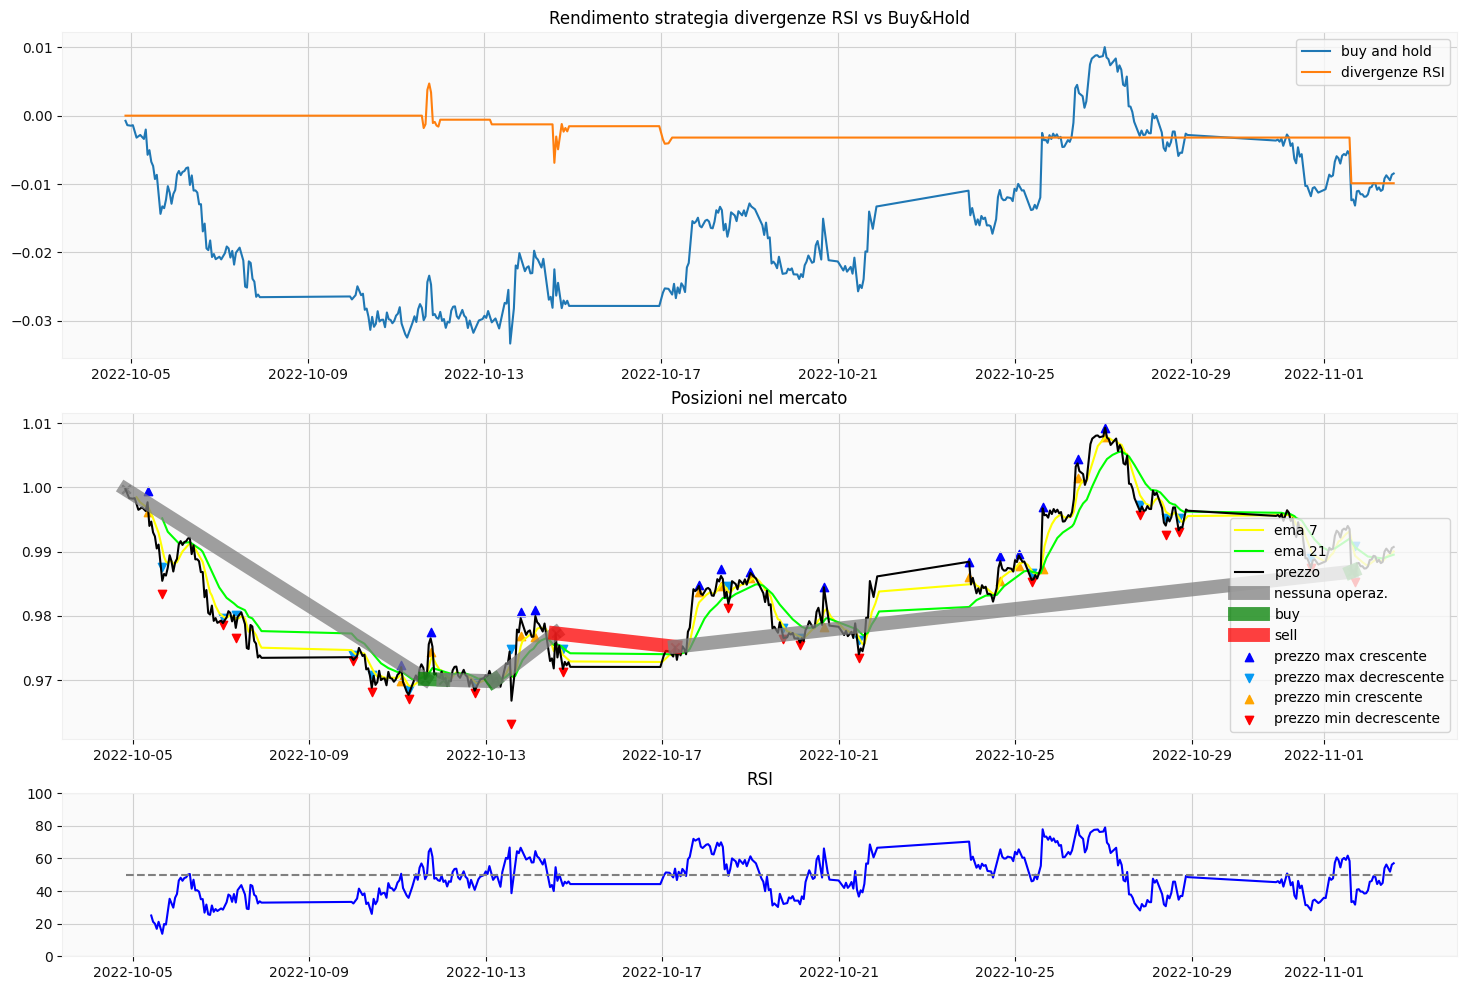

In [17]:
fig, (ax_returns, ax_positions, ax_rsi) = plt.subplots(3, figsize=(18, 12), gridspec_kw={'height_ratios': [2, 2, 1]})

# guadagni / perdite
ax_returns.plot(res['cum_returns'], label='buy and hold')
ax_returns.plot(res['strat_cum_returns'], label='divergenze RSI')
ax_returns.set_title('Rendimento strategia divergenze RSI vs Buy&Hold')
ax_returns.legend()

# prezzo e le due ema del prezzo
ax_positions.plot(res['ema_' + str(ema1)], label='ema ' + str(ema1), color='yellow')
ax_positions.plot(res['ema_' + str(ema2)], label='ema ' + str(ema2), color='lime')
ax_positions.plot(res['close'], label='prezzo', color='black')

# posizioni sul mercato
xs, ys, cs, ls = [], [], [], []
xs.append(res.iloc[0].name)
ys.append(res.iloc[0].close)
cs.append('gray')
ls.append('nessuna operaz.')

res['position_1'] = res['position'].shift(1)

xs.append(res.iloc[0].name)
ys.append(res.iloc[0].close)
cs.append('gray')
ls.append('nessuna operaz.')

for i in range(1, len(res)):
    c = res.iloc[i]
    if c.position != c.position_1:
        if c.position_1 == 1:
            cs.append('green')
            last_color = 'green'
            ls.append('buy')
            last_label = 'buy'
        elif c.position_1 == -1:
            cs.append('red')
            last_color = 'red'
            ls.append('sell')
            last_label = 'sell'
        else:
            cs.append('gray')
            last_color = 'gray'
            ls.append('nessuna operaz.')
            last_label = 'nessuna operaz.'
        xs.append(c.name)
        ys.append(c.close)

operazioni = []

for i in range(len(xs)):
    id_start = i - 1
    id_end = i + 1
    if ls[i:id_end] not in operazioni:
        operazioni.append(ls[i:id_end])
        ax_positions.plot(xs[id_start:id_end], ys[id_start:id_end], color=cs[i], alpha=0.75, label=ls[i], linewidth=10)
    else:
        ax_positions.plot(xs[id_start:id_end], ys[id_start:id_end], color=cs[i], alpha=0.75, linewidth=10)
    ax_positions.scatter(xs[i], ys[i], color=cs[i], marker='x')

ax_positions.set_title('Posizioni nel mercato')

# picchi massimi / minimi crescenti / decrescenti
prices = res.close.values
highs = res.high.values
lows = res.low.values
dates = res.index

p_hh = picchi_crescenti_consecutivi(prices, order=5)
p_hh_idx = np.array([i[1] for i in p_hh])

p_lh = picchi_decrescenti_consecutivi(prices, order=5)
p_lh_idx = np.array([i[1] for i in p_lh])

p_hl = picchi_crescenti_consecutivi(prices, order=5)
p_hl_idx = np.array([i[1] for i in p_hl])

p_ll = picchi_decrescenti_consecutivi(prices, order=5)
p_ll_idx = np.array([i[1] for i in p_ll])

ax_positions.scatter(dates[p_hh_idx], highs[p_hh_idx], marker='^', c='blue', label='prezzo max crescente')
ax_positions.scatter(dates[p_lh_idx], highs[p_lh_idx], marker='v', c='#069AF3', label='prezzo max decrescente')
ax_positions.scatter(dates[p_hl_idx], lows[p_hl_idx], marker='^', c='orange', label='prezzo min crescente')
ax_positions.scatter(dates[p_ll_idx], lows[p_ll_idx], marker='v', c='red', label='prezzo min decrescente')

ax_positions.legend()

ax_rsi.plot(res['rsi'], color='blue')
ax_rsi.hlines(50, xmin=res.index[0], xmax=res.index[-1], linestyles='--', color='gray')
ax_rsi.set_ylim(0, 100)
ax_rsi.set_title('RSI')
plt.show()